In [1]:
import os
import pandas as pd
import pickle
import numpy as np

In [2]:
from stellargraph import StellarGraph
from stellargraph.mapper import (CorruptedGenerator, FullBatchNodeGenerator)
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphInfomax, GAT
from stellargraph.utils import plot_history
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
from sklearn.preprocessing import normalize

2023-01-10 22:56:43.227673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
src_dir = './processed_data_inductive/'

nodes_DBLP_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_DBLP.csv'),
    index_col = 0
)


fpath_list = ['nodes_DBLP_edges_withRelations.csv']
df_edges = None
for fpath in fpath_list:
    _df = pd.read_csv( os.path.join(src_dir,fpath), index_col = None )
    if df_edges is None : df_edges = _df
    else:
        df_edges = df_edges.append(_df,ignore_index= True)

In [4]:
graph_obj = StellarGraph({
    "DBLP": nodes_DBLP_df
},
    df_edges, edge_type_column="orientation"
)

In [5]:
print(graph_obj.info())

StellarGraph: Undirected multigraph
 Nodes: 37493, Edges: 301369

 Node types:
  DBLP: [37493]
    Features: float32 vector, length 2470
    Edge types: DBLP->Paper-Author->DBLP, DBLP->Paper-Conference->DBLP, DBLP->Paper-Term->DBLP

 Edge types:
    DBLP->Paper-Term->DBLP: [215283]
        Weights: all 1 (default)
        Features: none
    DBLP->Paper-Author->DBLP: [53084]
        Weights: all 1 (default)
        Features: none
    DBLP->Paper-Conference->DBLP: [33002]
        Weights: all 1 (default)
        Features: none


In [6]:
import keras
import time
class TimeHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [7]:
model_use_data_DIR = 'model_use_data'
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)
model_use_data_DIR = os.path.join(model_use_data_DIR,'DBLP')
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)


model_save_path = 'model_save_dir'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
model_save_path = os.path.join(model_save_path,'DBLP')
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
    

model_save_ComputationTimePerEpoch = 'model_save_ComputationTime'
if not os.path.exists(model_save_ComputationTimePerEpoch):
    os.mkdir(model_save_ComputationTimePerEpoch)
model_save_ComputationTimePerEpoch = os.path.join(model_save_ComputationTimePerEpoch,'DBLP')
if not os.path.exists(model_save_ComputationTimePerEpoch):
    os.mkdir(model_save_ComputationTimePerEpoch)
    

emb_fpath_GAT = os.path.join(model_use_data_DIR, 'embeddings_GAT.npy')
emb_fpath_GCN = os.path.join(model_use_data_DIR, 'embeddings_GCN.npy')
emb_fpath_RGCN = os.path.join(model_use_data_DIR, 'embeddings_RGCN.npy')
emb_fpath_HINSAGE = os.path.join(model_use_data_DIR, 'embeddings_HINSAGE.npy')

In [8]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
time_callback = TimeHistory()
def run_deep_graph_infomax(base_model, generator, epochs, reorder=lambda sequence, subjects: subjects):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(graph_obj.nodes(node_type='DBLP'))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)   
    history = model.fit(gen, epochs=epochs, verbose=2, callbacks=[time_callback])
    plot_history(history)
    
    return emb_model #, x_emb_in, x_emb_out, all_embeddings

Using GCN (local pooling) filters...


/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 - 3s - loss: 0.2078 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 3s - loss: 0.2102 - 3s/epoch - 3s/step
Epoch 3/100
1/1 - 3s - loss: 0.2064 - 3s/epoch - 3s/step
Epoch 4/100
1/1 - 3s - loss: 0.2092 - 3s/epoch - 3s/step
Epoch 5/100
1/1 - 3s - loss: 0.2106 - 3s/epoch - 3s/step
Epoch 6/100
1/1 - 3s - loss: 0.2127 - 3s/epoch - 3s/step
Epoch 7/100
1/1 - 3s - loss: 0.2120 - 3s/epoch - 3s/step
Epoch 8/100
1/1 - 3s - loss: 0.2063 - 3s/epoch - 3s/step
Epoch 9/100
1/1 - 3s - loss: 0.2093 - 3s/epoch - 3s/step
Epoch 10/100
1/1 - 3s - loss: 0.2090 - 3s/epoch - 3s/step
Epoch 11/100
1/1 - 3s - loss: 0.1996 - 3s/epoch - 3s/step
Epoch 12/100
1/1 - 3s - loss: 0.2017 - 3s/epoch - 3s/step
Epoch 13/100
1/1 - 3s - loss: 0.2066 - 3s/epoch - 3s/step
Epoch 14/100
1/1 - 3s - loss: 0.1969 - 3s/epoch - 3s/step
Epoch 15/100
1/1 - 3s - loss: 0.2100 - 3s/epoch - 3s/step
Epoch 16/100
1/1 - 3s - loss: 0.2243 - 3s/epoch - 3s/step
Epoch 17/100
1/1 - 3s - loss: 0.2042 - 3s/epoch - 3s/step
Epoch 18/100
1/1 - 3s -

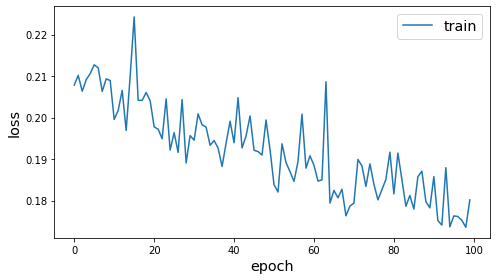

In [9]:
#GAT
fullbatch_generator_gat = FullBatchNodeGenerator(graph_obj, sparse=True)
gat_model = GAT(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator_gat, attn_heads=1)
gat = run_deep_graph_infomax(gat_model, fullbatch_generator_gat, epochs=100)

In [ ]:
#IN INDUCTIVE SETTINGS
fullbatch_generator_gat = FullBatchNodeGenerator(graph_obj, sparse=True)

In [10]:
#GAT OUTPUT
emb_gat_model_output = gat

In [11]:
#GAT EMBEDDING GENERATION
node_embeddings_gat = []
count = 0
#for i in range(len(graph_obj.nodes())):
#    vec = emb_gat_model_output.predict(fullbatch_generator_gat.flow([i]))
#    node_embeddings_gat.append(vec[0])
#for i in range(0,2470):
#    count+=1
#    vec = emb_gat_model_output.predict(fullbatch_generator_gat.flow([i]))
#    node_embeddings_gat.append(vec[0])
#    print(count)
    
for i in range(0,35472):
    node_embeddings_gat.append(0)
for i in range(35472,37472):
    count+=1
    vec = emb_gat_model_output.predict(fullbatch_generator_gat.flow([i]))
    node_embeddings_gat.append(vec[0])
    print(count)
for i in range(37472,37493):
    node_embeddings_gat.append(0)   
node_embeddings_GAT = np.array(node_embeddings_gat)
np.save(emb_fpath_GAT, node_embeddings_GAT)

1/1 [==============================] - 1s 692ms/step
1
1/1 [==============================] - 1s 547ms/step
2
1/1 [==============================] - 1s 563ms/step
3
1/1 [==============================] - 1s 548ms/step
4
1/1 [==============================] - 1s 557ms/step
5
1/1 [==============================] - 1s 552ms/step
6
1/1 [==============================] - 1s 561ms/step
7
1/1 [==============================] - 1s 548ms/step
8
1/1 [==============================] - 1s 557ms/step
9
1/1 [==============================] - 1s 555ms/step
10
1/1 [==============================] - 1s 564ms/step
11
1/1 [==============================] - 1s 546ms/step
12
1/1 [==============================] - 1s 588ms/step
13
1/1 [==============================] - 1s 543ms/step
14
1/1 [==============================] - 1s 561ms/step
15
1/1 [==============================] - 1s 550ms/step
16
1/1 [==============================] - 1s 557ms/step
17
1/1 [==============================] - 1s 548ms/step
18
1

1/1 [==============================] - 1s 556ms/step
146
1/1 [==============================] - 1s 575ms/step
147
1/1 [==============================] - 1s 553ms/step
148
1/1 [==============================] - 1s 580ms/step
149
1/1 [==============================] - 1s 555ms/step
150
1/1 [==============================] - 1s 587ms/step
151
1/1 [==============================] - 1s 555ms/step
152
1/1 [==============================] - 1s 593ms/step
153
1/1 [==============================] - 1s 551ms/step
154
1/1 [==============================] - 1s 572ms/step
155
1/1 [==============================] - 1s 558ms/step
156
1/1 [==============================] - 1s 618ms/step
157
1/1 [==============================] - 1s 555ms/step
158
1/1 [==============================] - 1s 585ms/step
159
1/1 [==============================] - 1s 569ms/step
160
1/1 [==============================] - 1s 587ms/step
161
1/1 [==============================] - 1s 560ms/step
162
1/1 [==========================

1/1 [==============================] - 1s 593ms/step
289
1/1 [==============================] - 1s 565ms/step
290
1/1 [==============================] - 1s 607ms/step
291
1/1 [==============================] - 1s 559ms/step
292
1/1 [==============================] - 1s 581ms/step
293
1/1 [==============================] - 1s 548ms/step
294
1/1 [==============================] - 1s 586ms/step
295
1/1 [==============================] - 1s 556ms/step
296
1/1 [==============================] - 1s 583ms/step
297
1/1 [==============================] - 1s 558ms/step
298
1/1 [==============================] - 1s 600ms/step
299
1/1 [==============================] - 1s 556ms/step
300
1/1 [==============================] - 1s 620ms/step
301
1/1 [==============================] - 1s 554ms/step
302
1/1 [==============================] - 1s 585ms/step
303
1/1 [==============================] - 1s 556ms/step
304
1/1 [==============================] - 1s 589ms/step
305
1/1 [==========================

1/1 [==============================] - 1s 552ms/step
432
1/1 [==============================] - 1s 578ms/step
433
1/1 [==============================] - 1s 563ms/step
434
1/1 [==============================] - 1s 607ms/step
435
1/1 [==============================] - 1s 563ms/step
436
1/1 [==============================] - 1s 617ms/step
437
1/1 [==============================] - 1s 564ms/step
438
1/1 [==============================] - 1s 587ms/step
439
1/1 [==============================] - 1s 564ms/step
440
1/1 [==============================] - 1s 590ms/step
441
1/1 [==============================] - 1s 566ms/step
442
1/1 [==============================] - 1s 589ms/step
443
1/1 [==============================] - 1s 556ms/step
444
1/1 [==============================] - 1s 614ms/step
445
1/1 [==============================] - 1s 587ms/step
446
1/1 [==============================] - 1s 618ms/step
447
1/1 [==============================] - 1s 564ms/step
448
1/1 [==========================

1/1 [==============================] - 1s 598ms/step
575
1/1 [==============================] - 1s 554ms/step
576
1/1 [==============================] - 1s 583ms/step
577
1/1 [==============================] - 1s 571ms/step
578
1/1 [==============================] - 1s 595ms/step
579
1/1 [==============================] - 1s 563ms/step
580
1/1 [==============================] - 1s 594ms/step
581
1/1 [==============================] - 1s 569ms/step
582
1/1 [==============================] - 1s 606ms/step
583
1/1 [==============================] - 1s 562ms/step
584
1/1 [==============================] - 1s 592ms/step
585
1/1 [==============================] - 1s 553ms/step
586
1/1 [==============================] - 1s 581ms/step
587
1/1 [==============================] - 1s 566ms/step
588
1/1 [==============================] - 1s 604ms/step
589
1/1 [==============================] - 1s 562ms/step
590
1/1 [==============================] - 1s 687ms/step
591
1/1 [==========================

1/1 [==============================] - 1s 574ms/step
718
1/1 [==============================] - 1s 617ms/step
719
1/1 [==============================] - 1s 680ms/step
720
1/1 [==============================] - 1s 566ms/step
721
1/1 [==============================] - 1s 577ms/step
722
1/1 [==============================] - 1s 586ms/step
723
1/1 [==============================] - 1s 557ms/step
724
1/1 [==============================] - 1s 592ms/step
725
1/1 [==============================] - 1s 565ms/step
726
1/1 [==============================] - 1s 593ms/step
727
1/1 [==============================] - 1s 558ms/step
728
1/1 [==============================] - 1s 586ms/step
729
1/1 [==============================] - 1s 563ms/step
730
1/1 [==============================] - 1s 591ms/step
731
1/1 [==============================] - 1s 568ms/step
732
1/1 [==============================] - 1s 588ms/step
733
1/1 [==============================] - 1s 564ms/step
734
1/1 [==========================

1/1 [==============================] - 1s 588ms/step
861
1/1 [==============================] - 1s 561ms/step
862
1/1 [==============================] - 1s 597ms/step
863
1/1 [==============================] - 1s 568ms/step
864
1/1 [==============================] - 1s 585ms/step
865
1/1 [==============================] - 1s 561ms/step
866
1/1 [==============================] - 1s 598ms/step
867
1/1 [==============================] - 1s 567ms/step
868
1/1 [==============================] - 1s 594ms/step
869
1/1 [==============================] - 1s 564ms/step
870
1/1 [==============================] - 1s 603ms/step
871
1/1 [==============================] - 1s 561ms/step
872
1/1 [==============================] - 1s 603ms/step
873
1/1 [==============================] - 1s 576ms/step
874
1/1 [==============================] - 1s 597ms/step
875
1/1 [==============================] - 1s 557ms/step
876
1/1 [==============================] - 1s 598ms/step
877
1/1 [==========================

1/1 [==============================] - 1s 549ms/step
1004
1/1 [==============================] - 1s 564ms/step
1005
1/1 [==============================] - 1s 552ms/step
1006
1/1 [==============================] - 1s 598ms/step
1007
1/1 [==============================] - 1s 548ms/step
1008
1/1 [==============================] - 1s 569ms/step
1009
1/1 [==============================] - 1s 556ms/step
1010
1/1 [==============================] - 1s 591ms/step
1011
1/1 [==============================] - 1s 547ms/step
1012
1/1 [==============================] - 1s 587ms/step
1013
1/1 [==============================] - 1s 552ms/step
1014
1/1 [==============================] - 1s 561ms/step
1015
1/1 [==============================] - 1s 606ms/step
1016
1/1 [==============================] - 1s 598ms/step
1017
1/1 [==============================] - 1s 582ms/step
1018
1/1 [==============================] - 1s 593ms/step
1019
1/1 [==============================] - 1s 564ms/step
1020
1/1 [=========

1/1 [==============================] - 1s 623ms/step
1145
1/1 [==============================] - 1s 562ms/step
1146
1/1 [==============================] - 1s 595ms/step
1147
1/1 [==============================] - 1s 556ms/step
1148
1/1 [==============================] - 1s 598ms/step
1149
1/1 [==============================] - 1s 556ms/step
1150
1/1 [==============================] - 1s 587ms/step
1151
1/1 [==============================] - 1s 555ms/step
1152
1/1 [==============================] - 1s 592ms/step
1153
1/1 [==============================] - 1s 614ms/step
1154
1/1 [==============================] - 1s 590ms/step
1155
1/1 [==============================] - 1s 559ms/step
1156
1/1 [==============================] - 1s 613ms/step
1157
1/1 [==============================] - 1s 553ms/step
1158
1/1 [==============================] - 1s 605ms/step
1159
1/1 [==============================] - 1s 623ms/step
1160
1/1 [==============================] - 1s 1s/step
1161
1/1 [============

1/1 [==============================] - 1s 582ms/step
1286
1/1 [==============================] - 1s 603ms/step
1287
1/1 [==============================] - 1s 573ms/step
1288
1/1 [==============================] - 1s 592ms/step
1289
1/1 [==============================] - 1s 560ms/step
1290
1/1 [==============================] - 1s 680ms/step
1291
1/1 [==============================] - 1s 583ms/step
1292
1/1 [==============================] - 1s 575ms/step
1293
1/1 [==============================] - 1s 705ms/step
1294
1/1 [==============================] - 1s 619ms/step
1295
1/1 [==============================] - 1s 557ms/step
1296
1/1 [==============================] - 1s 606ms/step
1297
1/1 [==============================] - 1s 645ms/step
1298
1/1 [==============================] - 1s 614ms/step
1299
1/1 [==============================] - 1s 552ms/step
1300
1/1 [==============================] - 1s 621ms/step
1301
1/1 [==============================] - 1s 563ms/step
1302
1/1 [=========

1/1 [==============================] - 1s 658ms/step
1427
1/1 [==============================] - 1s 566ms/step
1428
1/1 [==============================] - 1s 667ms/step
1429
1/1 [==============================] - 1s 573ms/step
1430
1/1 [==============================] - 1s 581ms/step
1431
1/1 [==============================] - 1s 620ms/step
1432
1/1 [==============================] - 1s 573ms/step
1433
1/1 [==============================] - 1s 573ms/step
1434
1/1 [==============================] - 1s 539ms/step
1435
1/1 [==============================] - 1s 558ms/step
1436
1/1 [==============================] - 1s 536ms/step
1437
1/1 [==============================] - 1s 550ms/step
1438
1/1 [==============================] - 1s 541ms/step
1439
1/1 [==============================] - 1s 558ms/step
1440
1/1 [==============================] - 1s 539ms/step
1441
1/1 [==============================] - 1s 551ms/step
1442
1/1 [==============================] - 1s 540ms/step
1443
1/1 [=========

1/1 [==============================] - 1s 842ms/step
1568
1/1 [==============================] - 1s 789ms/step
1569
1/1 [==============================] - 1s 816ms/step
1570
1/1 [==============================] - 1s 790ms/step
1571
1/1 [==============================] - 1s 816ms/step
1572
1/1 [==============================] - 1s 793ms/step
1573
1/1 [==============================] - 1s 850ms/step
1574
1/1 [==============================] - 1s 906ms/step
1575
1/1 [==============================] - 1s 837ms/step
1576
1/1 [==============================] - 1s 808ms/step
1577
1/1 [==============================] - 1s 834ms/step
1578
1/1 [==============================] - 1s 793ms/step
1579
1/1 [==============================] - 1s 823ms/step
1580
1/1 [==============================] - 1s 788ms/step
1581
1/1 [==============================] - 1s 843ms/step
1582
1/1 [==============================] - 1s 789ms/step
1583
1/1 [==============================] - 1s 854ms/step
1584
1/1 [=========

1/1 [==============================] - 1s 643ms/step
1709
1/1 [==============================] - 1s 745ms/step
1710
1/1 [==============================] - 1s 653ms/step
1711
1/1 [==============================] - 1s 655ms/step
1712
1/1 [==============================] - 1s 639ms/step
1713
1/1 [==============================] - 1s 635ms/step
1714
1/1 [==============================] - 1s 669ms/step
1715
1/1 [==============================] - 1s 650ms/step
1716
1/1 [==============================] - 1s 578ms/step
1717
1/1 [==============================] - 1s 607ms/step
1718
1/1 [==============================] - 1s 578ms/step
1719
1/1 [==============================] - 1s 573ms/step
1720
1/1 [==============================] - 1s 579ms/step
1721
1/1 [==============================] - 1s 597ms/step
1722
1/1 [==============================] - 1s 608ms/step
1723
1/1 [==============================] - 1s 569ms/step
1724
1/1 [==============================] - 1s 587ms/step
1725
1/1 [=========

1/1 [==============================] - 1s 730ms/step
1851
1/1 [==============================] - 1s 618ms/step
1852
1/1 [==============================] - 1s 588ms/step
1853
1/1 [==============================] - 1s 634ms/step
1854
1/1 [==============================] - 1s 623ms/step
1855
1/1 [==============================] - 1s 566ms/step
1856
1/1 [==============================] - 1s 599ms/step
1857
1/1 [==============================] - 1s 591ms/step
1858
1/1 [==============================] - 1s 553ms/step
1859
1/1 [==============================] - 1s 568ms/step
1860
1/1 [==============================] - 1s 554ms/step
1861
1/1 [==============================] - 1s 567ms/step
1862
1/1 [==============================] - 1s 593ms/step
1863
1/1 [==============================] - 1s 590ms/step
1864
1/1 [==============================] - 1s 559ms/step
1865
1/1 [==============================] - 1s 602ms/step
1866
1/1 [==============================] - 1s 562ms/step
1867
1/1 [=========

1/1 [==============================] - 1s 575ms/step
1992
1/1 [==============================] - 1s 556ms/step
1993
1/1 [==============================] - 1s 580ms/step
1994
1/1 [==============================] - 1s 549ms/step
1995
1/1 [==============================] - 1s 588ms/step
1996
1/1 [==============================] - 1s 558ms/step
1997
1/1 [==============================] - 1s 585ms/step
1998
1/1 [==============================] - 1s 551ms/step
1999
1/1 [==============================] - 1s 577ms/step
2000


/var/folders/2b/x_m3n03152x9tj_8wc0mpq7w0000gn/T/ipykernel_6597/3204001432.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  node_embeddings_GAT = np.array(node_embeddings_gat)


In [12]:
#GAT EPOCHS TIME
times = time_callback.times
cumulative_times = times
for i in range(len(cumulative_times)):
    if(i>0):
        cumulative_times[i] = cumulative_times[i]+cumulative_times[i-1]
time_per_epoch = []
for i in range(1,101):
    time_per_epoch.append((i,cumulative_times[i-1]))
df_time_per_epoch = pd.DataFrame(time_per_epoch)
df_time_per_epoch.to_csv(model_save_ComputationTimePerEpoch + "/GAT_time_per_epoch.csv")

In [ ]:
#node_embeddings_normalized_GAT = normalize(node_embeddings_gat, axis=1, norm='l2')

In [13]:
entity_id_mapping = pd.read_csv(src_dir + 'entity_id_mapping.csv')

In [14]:
#GAT SAVING SKILL EMBEDDINGS
embedding_dict_gat = {'skill': {}}
for i, row in entity_id_mapping.iterrows(): 
    if row['domain'] == 'term':
        embedding_dict_gat['skill'].update({row['entity_id']: node_embeddings_gat[row['serial_id']]}) 
pickle.dump(embedding_dict_gat, open(model_save_path + '/embedding_dict_gat.pkl', 'wb'))

In [ ]:
#GAT SAVING USER EMBEDDINGS AND SKILL EMBEDDINGS using L2 normalization
embedding_dict_gat = {'user': {}, 'skill': {}}
for i, row in entity_id_mapping.iterrows():
    if row['domain'] == 'author':
        embedding_dict_gat['user'].update({row['entity_id']: node_embeddings_normalized_GAT[row['serial_id']]})  
    elif row['domain'] == 'term':
        embedding_dict_gat['skill'].update({row['entity_id']: node_embeddings_normalized_GAT[row['serial_id']]}) 
pickle.dump(embedding_dict_gat, open(model_save_path + '/embedding_dict_gat.pkl', 'wb'))

In [ ]:
#GAT SAVING USER EMBEDDINGS AND SKILL EMBEDDINGS without L2 normalization
embedding_dict_gat = {'user': {}, 'skill': {}}
for i, row in entity_id_mapping.iterrows():
    if row['domain'] == 'author':
        embedding_dict_gat['user'].update({row['entity_id']: node_embeddings_gat[row['serial_id']]})  
    elif row['domain'] == 'term':
        embedding_dict_gat['skill'].update({row['entity_id']: node_embeddings_gat[row['serial_id']]}) 
pickle.dump(embedding_dict_gat, open(model_save_path + '/embedding_dict_gat.pkl', 'wb'))

In [ ]:
#GAT SAVING USER EMBEDDINGS, SKILL EMBEDDINGS AND CONFERENCE EMBEDDINGS
embedding_dict_USC_gat = {'user': {}, 'skill': {}, 'conf':{}}
for i, row in entity_id_mapping.iterrows():
    if row['domain'] == 'author':
        embedding_dict_USC_gat['user'].update({row['entity_id']: node_embeddings_normalized_GAT[row['serial_id']]})  
    elif row['domain'] == 'term':
        embedding_dict_USC_gat['skill'].update({row['entity_id']: node_embeddings_normalized_GAT[row['serial_id']]})
    elif row['domain'] == 'conf':
        embedding_dict_USC_gat['conf'].update({row['entity_id']: node_embeddings_normalized_GAT[row['serial_id']]})
        
pickle.dump(embedding_dict_USC_gat, open(model_save_path + '/embedding_dict_USC_gat.pkl', 'wb'))